In [6]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import json

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('/home/jko/ice3d')
from models.mlp_regression import MLPRegression 
from models.mlp_classification import MLPClassification 
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from data.tabular_dataset import TabularDataset
from data.tabular_datamodule import TabularDataModule

Global settings for notebook

In [7]:
# set parameters
n_rand = 666 # random seed
lr = 1e-3
num_epochs = 20
# Load the class mapping from a JSON file
class_mapping_file = '/home/jko/ice3d/data/class_to_idx.json'
# Load class mapping from JSON file
with open(class_mapping_file, 'r') as f:
    class_to_idx = json.load(f)
num_classes = len(class_to_idx)  # Number of unique classes in n_arms
# set indices of train/val/test sets
split = [0.7, 0.15, 0.15]
n_data = 700_000
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used
train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))
# define log transform for later
def log_transform(x):
    return torch.log(x)

# 1. Single view (default)

In [8]:
data_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
data_file = 'ros-tabular-data-shuffled-default-subset-700000.parquet'
data_path = os.path.join(data_dir, data_file)

## a) Regression

In [ ]:
n_rand = 666 # random seed
data_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
data_file = 'ros-tabular-data-shuffled-default-subset-700000.parquet'
data_path = os.path.join(data_dir, data_file)
lr = 1e-3
num_epochs = 50

# create train/test set
df = pd.read_parquet(data_path)
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['rho_eff', 'sa_eff']
df.reset_index(inplace=True)
# define log transform for later
def log_transform(x):
    return torch.log(x)
df_features = df[features]
df_targets = df[targets]
X = df_features
y = df_targets
print(len(X), len(y))

In [ ]:
# set indices of train/val/test sets
split = [0.7, 0.15, 0.15]
n_data = len(X)
assert abs(sum(split) - 1.0) < 1e-8, "Split does not sum to 1"
# Calculate split indices
n_train = int(split[0] * n_data)
n_val = int(split[1] * n_data)
n_test = n_data - n_train - n_val  # ensures all data is used

train_idx = list(range(0, n_train))
val_idx = list(range(n_train, n_train + n_val))
test_idx = list(range(n_train + n_val, n_data))

print(f"Train indices: {train_idx[0]} to {train_idx[len(train_idx)-1]}")
print(f"Val indices: {val_idx[0]} to {val_idx[len(val_idx)-1]}")
print(f"Test indices: {test_idx[0]} to {test_idx[len(test_idx)-1]}")

In [ ]:

dm = TabularDataModule(
    data_file=data_path,
    feature_names=features,
    target_names=targets,
    batch_size=64,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=16,
    task_type='regression',
    class_to_idx=None,
    target_transform=log_transform,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)

In [ ]:
dm.setup()

In [ ]:
model = MLPRegression(input_size=len(features), 
output_size=len(targets),
learning_rate=lr)


In [ ]:
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-regression-subset-70k-tb'
csv_log_name = f'mlp-regression-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)

In [ ]:
# Set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)

# Train the model
trainer.fit(model, dm)

In [ ]:
# plot loss curve
log_path = '/home/jko/ice3d/models/lightning_logs/mlp-regression-subset-70k-csv/version_0/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# load model from checkpoint
model_ckpt = '/home/jko/ice3d/models/lightning_logs/mlp-regression-subset-70k-csv/version_0/checkpoints/epoch=31-step=245024.ckpt'
model = MLPRegression.load_from_checkpoint(
    model_ckpt,
    input_size=len(features), 
    output_size=len(targets),
    learning_rate=lr
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

In [ ]:
print(device)

In [ ]:
# Convert test data to PyTorch tensors
test_loader = dm.test_dataloader()
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        print(features, targets)
        # preds = model(features)

In [ ]:
# Convert test data to PyTorch tensors
test_loader = dm.test_dataloader()
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        # Apply inverse log transform to both predictions and targets
        preds = torch.exp(preds)  # Inverse of log
        targets = torch.exp(targets)  # Inverse of log
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute R² values
r2_rho = r2_score(all_targets[:, 0], all_preds[:, 0])
r2_sa = r2_score(all_targets[:, 1], all_preds[:, 1])
print(f'R² for rho_eff: {r2_rho:.2f}')
print(f'R² for sa_eff: {r2_sa:.2f}')

# Plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rho_eff
axes[0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.5, edgecolor='white')
axes[0].plot([all_targets[:, 0].min(), all_targets[:, 0].max()],
             [all_targets[:, 0].min(), all_targets[:, 0].max()], 'k--', lw=2)
axes[0].set_title(f'rho_eff (R² = {r2_rho:.2f})')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

# Scatter plot for sa_eff
axes[1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.5, edgecolor='white')
axes[1].plot([all_targets[:, 1].min(), all_targets[:, 1].max()],
             [all_targets[:, 1].min(), all_targets[:, 1].max()], 'k--', lw=2)
axes[1].set_title(f'sa_eff (R² = {r2_sa:.2f})')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

## b) Classification

In [9]:
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['n_arms']
# instantiate data module
dm = TabularDataModule(
    data_file=data_path,
    feature_names=features,
    target_names=targets,
    batch_size=64,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=16,
    task_type='classification',
    class_to_idx=class_to_idx,
    target_transform=None,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()
# iniate model
model = MLPClassification(input_size=len(features), 
num_classes=num_classes,
learning_rate=lr)
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-classification-subset-70k-tb'
csv_log_name = f'mlp-classification-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
# Set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)
# Train the model
trainer.fit(model, dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 1.2 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 231    | train
----------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 19: 100%|██████████| 7657/7657 [07:15<00:00, 17.59it/s, v_num=1]      

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7657/7657 [07:15<00:00, 17.59it/s, v_num=1]


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')


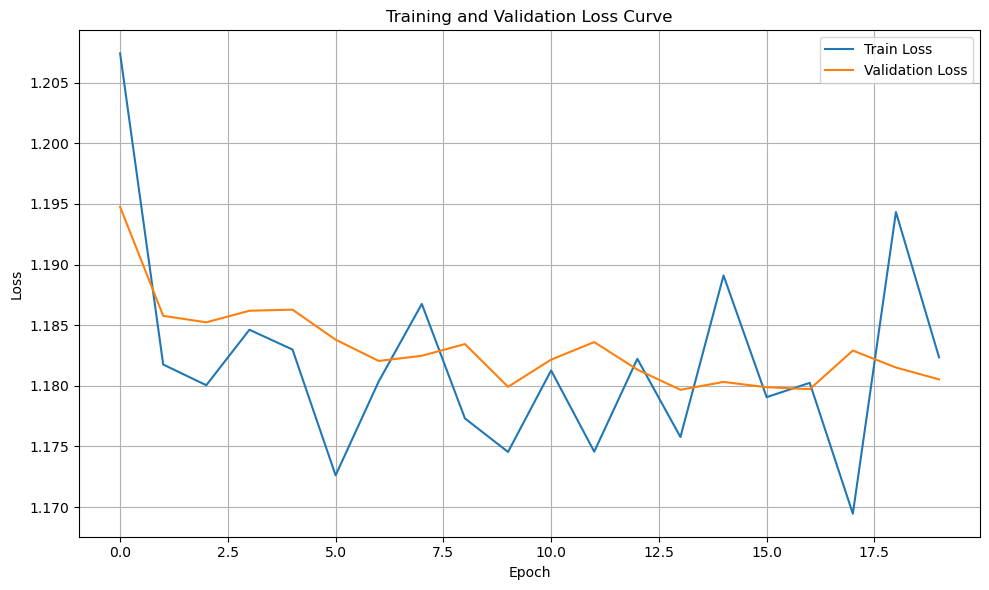

In [10]:
# plot loss curve
log_path = '/home/jko/ice3d/models/lightning_logs/mlp-classification-subset-70k-csv/version_1/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
features = ['aspect_ratio', 'aspect_ratio_elip', 'extreme_pts', 
        'contour_area', 'contour_perimeter', 'area_ratio', 'complexity', 
        'circularity']
targets = ['n_arms']
len(features)

8

Processing batch 1 out of 1641...
Processing batch 2 out of 1641...
Processing batch 3 out of 1641...
Processing batch 4 out of 1641...
Processing batch 5 out of 1641...
Processing batch 6 out of 1641...
Processing batch 7 out of 1641...
Processing batch 8 out of 1641...
Processing batch 9 out of 1641...
Processing batch 10 out of 1641...
Processing batch 11 out of 1641...
Processing batch 12 out of 1641...
Processing batch 13 out of 1641...
Processing batch 14 out of 1641...
Processing batch 15 out of 1641...
Processing batch 16 out of 1641...
Processing batch 17 out of 1641...
Processing batch 18 out of 1641...
Processing batch 19 out of 1641...
Processing batch 20 out of 1641...
Accuracy: 0.47


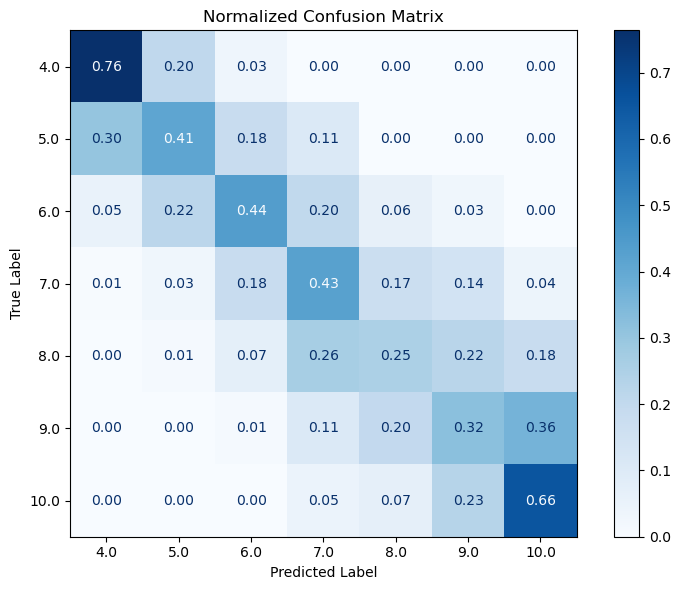

In [16]:
# load model from checkpoint
model_ckpt = '/home/jko/ice3d/models/lightning_logs/mlp-classification-subset-70k-csv/version_1/checkpoints/epoch=19-step=153140.ckpt'
model = MLPClassification.load_from_checkpoint(
    model_ckpt,
    input_size=len(features), 
    num_classes=num_classes,
    learning_rate=lr
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Convert test data to PyTorch tensors
test_loader = dm.test_dataloader()
all_preds = []
all_targets = []
n_batches = 20  # Number of batches to process

# Run inference on the test data and print progress
with torch.no_grad():
    total_batches = len(test_loader)
    for i, batch in enumerate(test_loader):
        if i >= n_batches:  # Stop after 20 batches
            break
        print(f"Processing batch {i + 1} out of {total_batches}...")
        features, targets = batch
        features = features.to(device)
        targets = targets.to(device)
        preds = model(features)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Convert model outputs to predicted class indices
pred_labels = np.argmax(all_preds, axis=1)

# Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_targets, pred_labels)
print(f'Accuracy: {accuracy:.2f}')

# Compute confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(all_targets, pred_labels, normalize='true')
class_labels = list(class_to_idx.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 2. Stereo view (2DS)

In [ ]:
data_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
data_file = 'ros-tabular-data-stereo-default-2ds-shuffled-subset-700000.parquet'
data_path = os.path.join(data_dir, data_file)

## a) Regression

In [ ]:
# initiate data module
dm = TabularDataModule(
    data_file=data_path,
    feature_names=features,
    target_names=targets,
    batch_size=64,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=16,
    task_type='regression',
    class_to_idx=None,
    target_transform=log_transform,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()
# iniate model
model = MLPRegression(input_size=len(features), 
output_size=len(targets),
learning_rate=lr)
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-regression-stereo-2ds-subset-70k-tb'
csv_log_name = f'mlp-regression-stereo-2ds-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
# set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)
# Train the model
trainer.fit(model, dm)

## b) Classification

In [ ]:
# initiate data module
dm = TabularDataModule(
    data_file=data_path,
    feature_names=features,
    target_names=targets,
    batch_size=64,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=16,
    task_type='classification',
    class_to_idx=class_to_idx,
    target_transform=None,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()
# iniate model
model = MLPClassification(input_size=len(features), 
num_classes=num_classes,
learning_rate=lr)
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-classification-stereo-2ds-subset-70k-tb'
csv_log_name = f'mlp-classification-stereo-2ds-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
# set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)
# Train the model
trainer.fit(model, dm)

# 3. Stereo View (PHIPS)

In [ ]:
data_dir = '/home/jko/synth-ros-data/tabular-data-v2/shuffled_small'
data_file = 'ros-tabular-data-stereo-default-phips-shuffled-subset-700000.parquet'
data_path = os.path.join(data_dir, data_file)

## a) Regression

In [ ]:
# initiate data module
dm = TabularDataModule(
    data_file=data_path,
    feature_names=features,
    target_names=targets,
    batch_size=64,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=16,
    task_type='regression',
    class_to_idx=None,
    target_transform=log_transform,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()
# iniate model
model = MLPRegression(input_size=len(features), 
output_size=len(targets),
learning_rate=lr)
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-regression-stereo-phips-subset-70k-tb'
csv_log_name = f'mlp-regression-stereo-phips-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
# set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)
# Train the model
trainer.fit(model, dm)

## b) Classification

In [ ]:
# initiate data module
dm = TabularDataModule(
    data_file=data_path,
    feature_names=features,
    target_names=targets,
    batch_size=64,
    subset_size=1.0,
    subset_seed=n_rand,
    num_workers=16,
    task_type='classification',
    class_to_idx=class_to_idx,
    target_transform=None,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)
dm.setup()
# iniate model
model = MLPClassification(input_size=len(features), 
num_classes=num_classes,
learning_rate=lr)
# Set up logger information
log_dir = '/home/jko/ice3d/models/lightning_logs'
tb_log_name = f'mlp-classification-stereo-phips-subset-70k-tb'
csv_log_name = f'mlp-classification-stereo-phips-subset-70k-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
# set up trainer
trainer = Trainer(
    max_epochs=num_epochs,
    accelerator="gpu",
    logger=[csv_logger, tb_logger],
    enable_progress_bar=True,
)
# Train the model
trainer.fit(model, dm)